In [140]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [141]:
df = pd.read_csv("Ask a manager salary survey - REAL.csv")
print("Dataset Dimensions:", df.shape)

df_info = pd.DataFrame({
    "Column Name": df.dtypes.index,
    "Data Type": df.dtypes.values,
    "Sample Values": [df[col].dropna().unique()[:3] for col in df.columns]  # Show up to 3 unique sample values
})

print("\nDataset Features:")
display(df_info)


Dataset Dimensions: (10339, 19)

Dataset Features:


,Column Name,Data Type,Sample Values
0,timestamp,object,"[4/27/2021 11:02, 4/27/2021 11:03, 4/27/2021 1..."
1,age,object,"[25-34, 45-54, 35-44]"
2,industry,object,"[Business, Finance & Consulting, Computing & T..."
3,job_title,object,"[Marketing Specialist, Accounting Manager, Sys..."
4,job_context,object,"[Data developer/ETL Developer, supervisor leve..."
5,annual_salary,object,"[34,000, 60,000, 112,000]"
6,additional_comp,float64,"[7000.0, 10000.0, 0.0]"
7,currency,object,"[USD, GBP, CAD]"
8,"If ""Other,"" please indicate the currency here:",object,"[INR, Peso Argentino, MYR]"
9,income_context,object,"[I work for a Charter School, Commission based..."


# Handling Data Issues:

### 1- missing values

In [142]:
# replace ['currency'] == 'Other' with ['If "Other," please indicate the currency here: ']
col_other = 'If "Other," please indicate the currency here: '

df["currency"] = df.apply(
    lambda row: row[col_other] if row["currency"] == "Other" and pd.notna(row[col_other]) else row["currency"],
    axis=1
)

In [143]:
# drop missing value in job_title
df = df.dropna(subset=["job_title"])

# drop ['if "Other", please...] cloumn
df = df.drop(columns=['If "Other," please indicate the currency here: '])
df = df.drop(columns=['work_city'])

# replace nan with (0) in ['additional_comp']
df["additional_comp"] = df["additional_comp"].fillna(0)

df["race"] = df["race"].fillna("Other")
df["gender"] = df["gender"].fillna("Other or prefer not to answer")

# calculate ['education_level'] mode for each ['job_title']
job_education_mode = df.groupby('job_title')['education_level'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

df['education_level'] = df.apply(
    lambda row: job_education_mode[row['job_title']] if pd.isna(row['education_level']) else row['education_level'],
    axis=1
)

display(df[['job_title', 'education_level']].head(10))

,job_title,education_level
0,Marketing Specialist,College degree
1,Accounting Manager,College degree
2,Systems Analyst,College degree
3,Senior Accountant,College degree
4,Executive Assistant,Some college
5,Senior Manager,Master's degree
6,Researcher,PhD
7,Economist,Master's degree
8,Research Engineer,College degree
9,Editor,Master's degree


In [144]:
# ✅ Check for missing data

# Count missing values (NaN)
missing_values = df.isna().sum()

# Count empty string values ("" or just spaces)
empty_values = df.astype(str).applymap(lambda x: x.strip() == "" if pd.notna(x) else False).sum()

# Calculate total missing (NaN + Empty Strings)
total_missing = missing_values + empty_values

# Create a summary DataFrame
completeness_report = pd.DataFrame({
    "Total Values": len(df),
    "Missing (NaN)": missing_values,
    "Empty Strings": empty_values,
    "Total Missing": total_missing,
    "Missing %": (total_missing / len(df)) * 100
})

# Filter to show only columns with missing values
completeness_report = completeness_report[completeness_report["Total Missing"] > 0]

if completeness_report.empty:
    print("✅ No missing values found in the dataset!")
else:
    print("\n🔍 Completeness Check Report:")
    display(completeness_report)

    # Display sample rows with missing values for each column
    for col in completeness_report.index:
        print(f"\n❌ Examples of Missing Data in '{col}':")
        display(df[df[col].isna() | (df[col].astype(str).str.strip() == "")].head(3))


🔍 Completeness Check Report:


C:\Users\sjood\AppData\Local\Temp\ipykernel_5752\1839690080.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  empty_values = df.astype(str).applymap(lambda x: x.strip() == "" if pd.notna(x) else False).sum()


,Total Values,Missing (NaN),Empty Strings,Total Missing,Missing %
job_context,10339,8216,4,8220,79.504788
income_context,10339,9296,1,9297,89.921656
work_state,10339,1905,0,1905,18.425380



❌ Examples of Missing Data in 'job_context':


,timestamp,age,industry,job_title,job_context,annual_salary,additional_comp,currency,income_context,work_country,work_state,years_experience_total,years_experience_field,education_level,gender,race,mean_age
0,4/27/2021 11:02,25-34,"Business, Finance & Consulting",Marketing Specialist,NaN,"34,000",0.0,USD,NaN,US,Tennessee,2 - 4 years,2 - 4 years,College degree,Woman,White,29.5
1,4/27/2021 11:02,25-34,"Business, Finance & Consulting",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,US,South Carolina,8 - 10 years,5-7 years,College degree,Woman,White,29.5
3,4/27/2021 11:03,35-44,"Business, Finance & Consulting",Senior Accountant,NaN,"45,000",0.0,USD,I work for a Charter School,United States,Florida,21 - 30 years,21 - 30 years,College degree,Woman,"Hispanic, Latino, or Spanish origin, White",39.5



❌ Examples of Missing Data in 'income_context':


,timestamp,age,industry,job_title,job_context,annual_salary,additional_comp,currency,income_context,work_country,work_state,years_experience_total,years_experience_field,education_level,gender,race,mean_age
0,4/27/2021 11:02,25-34,"Business, Finance & Consulting",Marketing Specialist,NaN,"34,000",0.0,USD,NaN,US,Tennessee,2 - 4 years,2 - 4 years,College degree,Woman,White,29.5
1,4/27/2021 11:02,25-34,"Business, Finance & Consulting",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,US,South Carolina,8 - 10 years,5-7 years,College degree,Woman,White,29.5
2,4/27/2021 11:03,45-54,Computing & Technology,Systems Analyst,Data developer/ETL Developer,"112,000",10000.0,USD,NaN,US,Missouri,21 - 30 years,21 - 30 years,College degree,Woman,White,49.5



❌ Examples of Missing Data in 'work_state':


,timestamp,age,industry,job_title,job_context,annual_salary,additional_comp,currency,income_context,work_country,work_state,years_experience_total,years_experience_field,education_level,gender,race,mean_age
15,4/27/2021 11:04,35-44,"Business, Finance & Consulting",Senior Copywriter,NaN,"35,000",6000.0,GBP,NaN,UK,NaN,11 - 20 years,11 - 20 years,College degree,Woman,White,39.5
19,4/27/2021 11:04,35-44,Computing & Technology,Editor,NaN,"52,000",0.0,CAD,NaN,Canada,NaN,11 - 20 years,11 - 20 years,College degree,Woman,Asian or Asian American,39.5
22,4/27/2021 11:04,25-34,Government & Public Services,Senior Advisor,NaN,"79,000",0.0,CAD,NaN,Canada,NaN,8 - 10 years,5-7 years,Master's degree,Woman,White,29.5


**Handling Duplicate Records**

In [145]:
#Handling Duplicate Records (keep first)
DataBefore = df.shape[0]

df = df.drop_duplicates(keep="first")

DataAfter = df.shape[0]
print(f"Removed {DataBefore - DataAfter} exact duplicate records - kept the first occurrence only.")

Removed 10 exact duplicate records - kept the first occurrence only.


### 2- Data Type Issues

In [146]:
df["annual_salary"] = (
    df["annual_salary"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.strip()
    .replace("", pd.NA)
    .astype(float)
)

In [147]:
print(df.dtypes)

print("\nConverting salary and experience columns to numeric")
numeric_cols = ["additional_comp"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nUpdated data types after numeric conversion:")
print(df[numeric_cols].dtypes)

print("\nConverting timestamp column to datetime.")
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
print("Timestamp conversion complete.")

print("\nCleaning and standardizing text columns")
string_cols = ["industry", "job_title", "gender", "education_level", "work_country"]

for col in string_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

print("String cleaning complete.")

print("\nConverting gender, education level, industry, race columns to categorical types")
categorical_cols = ["gender", "education_level", "industry", "race"]

for col in categorical_cols:
    df[col] = df[col].astype("category")

print("\nAll Done!")

timestamp                  object
age                        object
industry                   object
job_title                  object
job_context                object
annual_salary             float64
additional_comp           float64
currency                   object
income_context             object
work_country               object
work_state                 object
years_experience_total     object
years_experience_field     object
education_level            object
gender                     object
race                       object
mean_age                  float64
dtype: object

Converting salary and experience columns to numeric

Updated data types after numeric conversion:
additional_comp    float64
dtype: object

Converting timestamp column to datetime.
Timestamp conversion complete.

Cleaning and standardizing text columns
String cleaning complete.

Converting gender, education level, industry, race columns to categorical types

All Done!


In [148]:
df["age"] = df["age"].astype("category")

In [149]:
def midpoint(value):
    if pd.isna(value):
        return np.nan
    
    value = str(value).strip().lower()
    
    if "less" in value:
        return 0.5
    
    if "more" in value:
        return 41
    
    match = re.findall(r'\d+', value)
    if len(match) == 2:
        low, high = map(int, match)
        return (low + high) / 2
    
    return np.nan

In [150]:
df["years_experience_total"] = df["years_experience_total"].apply(midpoint).astype(float)
df["years_experience_field"] = df["years_experience_field"].apply(midpoint).astype(float)

### 3- Inconsistent Data

In [151]:
country_map = {
    "united states": "USA",
    "us": "USA",
    "u.s.": "USA",
    "u.s": "USA",
    "u.s>": "USA",
    "u.s.a": "USA",
    "u.s.a.": "USA",
    "us of a": "USA",
    "usa": "USA",
    "usa-- virgin islands": "USA",
    "usa tomorrow": "USA",
    "usaa": "USA",
    "usab": "USA",
    "usat": "USA",
    "uss": "USA",
    "united states of america": "USA",
    "united state": "USA",
    "united stated": "USA",
    "united statws": "USA",
    "united sates": "USA",
    "united states of american": "USA",
    "united sates of america": "USA",
    "united statesp": "USA",
    "united stattes": "USA",
    "united statea": "USA",
    "united statees": "USA",
    "united statues": "USA",
    "untied states": "USA",
    "unitied states": "USA",
    "uniter statez": "USA",
    "united stateds": "USA",
    "uniteed states": "USA",
    "united stares": "USA",
    "united statss": "USA",
    "unite states": "USA",
    "united statew": "USA",
    "united states is america": "USA",
    "unitedstates": "USA",
    "united  states": "USA",
    "united states- puerto rico": "USA",
    "🇺🇸": "USA",
    "america": "USA",
    "the united states": "USA",
    "the us": "USA",
    "united states of americas": "USA",
    "united states of americas": "USA",
    "uniited states": "USA",
    "uniyed states": "USA",
    "uniyes states": "USA",
    "united statss": "USA",
    "united stattes": "USA",
    "united states of americas": "USA",
    "u. s":"USA",
    "u. s.":"USA",
    "united state of america":"USA",
    "united sttes":"USA",
    "unites states":"USA",
    "usd":"USA",
    
    "united kingdom": "UK",
    "uk": "UK",
    "u.k.": "UK",
    "u.k": "UK",
    "england": "UK",
    "scotland": "UK",
    "britain": "UK",
    "great britain": "UK",
    "england/uk": "UK",
    "england, uk.": "UK",
    "england, gb": "UK",
    "england, united kingdom": "UK",
    "wales": "UK",
    "wales (united kingdom)": "UK",
    "wales, uk": "UK",
    "northern ireland": "UK",
    "northern ireland, united kingdom": "UK",
    "uk (northern ireland)": "UK",
    "uk (england)": "UK",
    "uk, remote": "UK",
    "scotland, uk": "UK",
    "united kingdom.": "UK",
    "united kingdom (england)": "UK",
    "united kingdomk": "UK",
    "united kindom": "UK",
    "unites kingdom": "UK",
    "u.k. (northern england)": "UK",
    "uk for u.s. company": "UK",
    "uk, but for globally fully remote company": "UK",
    "england, uk":"UK",
    "isle of man":"UK",
    "jersey, channel islands":"UK",

    "canada": "Canada",
    "can": "Canada",
    "canda": "Canada",
    "canad": "Canada",
    "canadw": "Canada",
    "csnada": "Canada",
    "canadá": "Canada",
    "canada, ottawa, ontario": "Canada",
    "canada and usa": "Canada",

    "netherlands": "Netherlands",
    "the netherlands": "Netherlands",
    "nederland": "Netherlands",
    "nl": "Netherlands",

    "australia": "Australia",
    "australi": "Australia",
    "australian": "Australia",
    "Austria":"Australia",
    
    "new zealand": "New Zealand",
    "nz": "New Zealand",
    "aotearoa new zealand": "New Zealand",
    "new zealand aotearoa": "New Zealand",

    "france": "France",
    "germany": "Germany",
    "spain": "Spain",
    "italy": "Italy",
    "italia": "Italy",
    "italy (south)": "Italy",
    "ireland": "Ireland",
    "hungary": "Hungary",
    "luxembourg": "Luxembourg",
    "luxemburg": "Luxembourg",
    "switzerland": "Switzerland",
    "sweden": "Sweden",
    "norway": "Norway",
    "denmark": "Denmark",
    "danmark": "Denmark",
    "finland": "Finland",
    "belgium": "Belgium",
    "austria": "Austria",
    "brazil": "Brazil",
    "brasil": "Brazil",
    "mexico": "Mexico",
    "méxico": "Mexico",
    "argentina": "Argentina",
    "colombia": "Colombia",
    "chile": "Chile",
    "cuba": "Cuba",
    "jamaica": "Jamaica",
    "trinidad and tobago": "Trinidad and Tobago",
    "puerto rico": "Puerto Rico",
    "panamá": "Panama",
    "costa rica": "Costa Rica",
    "ecuador": "Ecuador",
    "peru": "Peru",
    "uruguay": "Uruguay",
    "venezuela": "Venezuela",
    "philippines": "Philippines",
    "india": "India",
    "china": "China",
    "mainland china": "China",
    "taiwan": "Taiwan",
    "hong kong": "Hong Kong",
    "hong konh": "Hong Kong",
    "hong kongkong": "Hong Kong",
    "japan": "Japan",
    "russia": "Russia",
    "poland": "Poland",
    "romania": "Romania",
    "czech republic": "Czech Republic",
    "czechia": "Czech Republic",
    "latvia": "Latvia",
    "lithuania": "Lithuania",
    "slovakia": "Slovakia",
    "slovenia": "Slovenia",
    "portugal": "Portugal",
    "greece": "Greece",
    "turkey": "Turkey",
    "israel": "Palestine",
    "egypt": "Egypt",
    "south africa": "South Africa",
    "nigeria": "Nigeria",
    "ghana": "Ghana",
    "uganda": "Uganda",
    "kenya": "Kenya",
    "morocco": "Morocco",
    "somalia": "Somalia",
    "rwanda": "Rwanda",
    "zimbabwe": "Zimbabwe",
    "tanzania": "Tanzania",
    "sri lanka": "Sri Lanka",
    "indonesia": "Indonesia",
    "thailand": "Thailand",
    "vietnam": "Vietnam",
    "cambodia": "Cambodia",
    "malaysia": "Malaysia",
    "singapore": "Singapore",
    "south korea": "South Korea",
    "uae": "United Arab Emirates",
    "united arab emirates": "United Arab Emirates",
    "qatar": "Qatar",
    "kuwait": "Kuwait",
    "saudi arabia": "Saudi Arabia",
    "pakistan": "Pakistan",
    "afghanistan": "Afghanistan",
    "bangladesh": "Bangladesh",
    "cyprus": "Cyprus",
    "croatia": "Croatia",
    "serbia": "Serbia",
    "bulgaria": "Bulgaria",
    "estonia": "Estonia",
    "bosnia and herzegovina": "Bosnia and Herzegovina",
    "liechtenstein": "Liechtenstein",
    "luxembourg": "Luxembourg",
    "company in germany. i work from pakistan.":"Pakistan",
    "from romania, but for an us based company":"romania",

    "remote (philippines)":"philippines",
    "austria, but i work remotely for a dutch/british company":"Australia",
    "i am located in canada but i work for a company in the us": "canada",
    "usa (company is based in a us territory, i work remote)": "USA",
    "united states (i work from home and my clients are all over the us/canada/pr":"USA"
}

In [152]:
df["work_country"] = df["work_country"].str.lower().str.strip()
df["work_country"] = df["work_country"].map(country_map)
df = df.dropna(subset=["work_country"])

In [153]:
currency_map = {
    "USD": "USD",
    "AMERICAN DOLLARS": "USD",
    "US DOLLAR": "USD",
    "US DOLLARS": "USD",
    "US Dollar": "USD",
    "American Dollars": "USD",
    "AUD/NZD": "NZD",
    "AUD AUSTRALIAN": "AUD",
    "AUSTRALIAN DOLLARS": "AUD",
    "ARGENTINE PESO": "ARS",
    "ARGENTINIAN PESO (ARS)":"ARS",
    "PESO ARGENTINO":"ARS",
    "BR$": "BRL",
    "BRL (R$)": "BRL",
    "DANISH KRONER": "DKK",
    "CZECH CROWNS": "CZK",
    "EURO": "EUR",
    "INDIAN RUPEES": "INR",
    "INR (INDIAN RUPEE)": "INR",
    "MEXICAN PESOS": "MXN",
    "NORWEGIAN KRONER (NOK)":"NOK",
    "PHILIPPINE PESO": "PHP",
    "PHILIPPINE PESO (PHP)":"PHP",
    "PHILIPPINE PESOS": "PHP",
    "PHP (PHILIPPINE PESO)": "PHP",
    "PLN (POLISH ZLOTY)":"PLN",
    "PLN (ZWOTY)":"PLN",
    "POLISH ZŁOTY":"PLN",
    "THAI BAHT":"THB",
    "PESOS COLOMBIANOS":"COP",
    "NIS (NEW ISRAELI SHEKEL)": "NIS",
    "NIS":"NIS",
    "ILS (SHEKEL)": "NIS",
    "ILS/NIS": "NIS",
    "ISRAELI SHEKELS": "NIS" 
}

In [154]:
df["currency"] = df["currency"].str.upper().str.strip()
df["currency"] = df["currency"].map(lambda x: currency_map.get(x, x)).fillna(df["work_country"])
df = df[~df["currency"].isin(["OTHER", "NIS",])]

In [155]:
amount_col = "annual_salary"              
currency_col = "currency"           

# (1 unit of currency = how many SAR)

currency_to_sar = {
    "ARS": 0.037,  "AUD": 2.69,  "BRL": 0.73,  "CAD": 2.74,
    "CHF": 4.24,  "COP": 0.00091, "CZK": 0.18, "DKK": 0.57,
    "EUR": 4.50,  "GBP": 5.20,   "INR": 0.046, "JPY": 0.031,
    "LKR": 0.010, "MXN": 0.25,   "MYR": 0.88,  "NOK": 0.42,
    "NZD": 2.57,  "PHP": 0.080,  "PLN": 0.95,  "RM": 0.88,
    "SAR": 1.0,   "SEK": 0.42,   "SGD": 3.10,  "THB": 0.11,
    "TRY": 0.28,  "TZS": 0.0018, "USD": 3.75,  "ZAR": 0.21
}
    
df[amount_col] = (
    df[amount_col]
    .astype(str)
    .str.replace(",", "")
    .str.extract(r"(\d+\.?\d*)")[0]
    .astype(float)
)

df[currency_col] = df[currency_col].astype(str).str.upper().str.strip()

def convert_to_sar(amount, currency):
    try:
        rate = currency_to_sar.get(currency, None)
        if pd.isna(amount) or rate is None:
            return None
        return amount * rate
    except:
        return None


df[currency_col] = df[currency_col].astype(str).str.upper().str.strip()

df["annual_salary"] = df.apply(
    lambda row: row[amount_col] * currency_to_sar.get(row[currency_col], np.nan),
    axis=1
)

print(df[["annual_salary"]].head())

   annual_salary
0       127500.0
1       225000.0
2       420000.0
3       168750.0
4       318750.0


In [156]:
amount_col = "additional_comp"              
currency_col = "currency"           

df[amount_col] = (
    df[amount_col]
    .astype(str)
    .str.replace(",", "")
    .str.extract(r"(\d+\.?\d*)")[0]
    .astype(float)
)


def convert_to_sar(amount, currency):
    try:
        rate = currency_to_sar.get(currency, None)
        if pd.isna(amount) or rate is None:
            return None
        return amount * rate
    except:
        return None


df[currency_col] = df[currency_col].astype(str).str.upper().str.strip()

df["additional_comp"] = df.apply(
    lambda row: row[amount_col] * currency_to_sar.get(row[currency_col], np.nan),
    axis=1
)

print(df[["additional_comp"]].head())

   additional_comp
0              0.0
1          26250.0
2          37500.0
3              0.0
4          18750.0


**State Column**

In [157]:
valid_states = [
    "New York", "South Carolina", "North Carolina", "West Virginia", "Rhode Island", "District of Columbia",
    "New Mexico", "New Jersey", "South Dakota", "North Dakota", "New Hampshire","British Columbia", "Nova Scotia", "New Brunswick", "Prince Edward Island",
    "Newfoundland and Labrador","New South Wales", "Northern Territory", "Australian Capital Territory","Uttar Pradesh", "Madhya Pradesh", "Tamil Nadu", "West Bengal", "Andhra Pradesh", "Arunachal Pradesh",
    "Western Cape", "Eastern Cape", "Northern Cape", "Free State", "KwaZulu Natal","Mato Grosso", "Mato Grosso do Sul", "Rio Grande do Sul", "Rio Grande do Norte", "Espírito Santo", "Baja California", "Baja California Sur", "Nuevo León", "San Luis Potosí", "Quintana Roo","Bay of Plenty", "New Plymouth"]

valid_states = [s.lower() for s in valid_states]


df["two_words_states"] = df["work_state"].astype(str).str.lower().apply(
    lambda text: [state for state in valid_states if state in text] or None
)


df['work_state'] = df['work_state'].astype(str).map(lambda text: text.split()) 

stop_words = set(stopwords.words('english'))

df['work_state'] = df['work_state'].map(lambda words: [word for word in words \
                                               if word not in stop_words])


df["work_state"] = df.apply(
    lambda row: row["two_words_states"] if row["two_words_states"] is not None else row["work_state"],
    axis=1
)


df = df.explode("work_state")


df['work_state'] = df['work_state'].astype(str).str.strip(',')
df['work_state'] = df['work_state'].str.title()
df = df.drop(columns=["two_words_states"])

**race column**

In [158]:
race = df["race"].astype(str).str.strip()

replace_map = {
    "Asian or Asian American": "Asian",
    "Black or African American": "Black",
    "Hispanic, Latino, or Spanish origin": "Hispanic",
    "Middle Eastern or Northern African": "Middle Eastern",
    "Native American or Alaska Native": "Native American",
    "White": "White",
    "Another option not listed here or prefer not to answer": "Prefer not to answer"
}

for long, short in replace_map.items():
    race = race.str.replace(long, short, regex=False)

race = race.replace(["nan", "0", ""], "Unknown")

def clean_race(value):
    if value == "Unknown":
        return "Unknown"

    if "," in value:
        return "Mixed"

    return value

race_cleaned = race.apply(clean_race)
race_cleaned = race_cleaned.str.strip()

df["race"] = race_cleaned

race = df["race"].astype(str).str.strip()

**job_title column**

In [159]:
STOPWORDS_EN = set(stopwords.words('english'))
PUNCTUATION = set(string.punctuation)

WORDS_TO_REMOVE = {
    'job',
    'specialist',
}

ALL_STOP_WORDS = STOPWORDS_EN.union(WORDS_TO_REMOVE)

def clean_job_title(title):
    title = str(title).lower() 
    title = ''.join(char if char not in PUNCTUATION else ' ' for char in title)
    title = ' '.join(title.split())
    words = title.split()
    filtered_words = [word for word in words if word not in ALL_STOP_WORDS]
    return ' '.join(filtered_words)

df['job_title'] = df['job_title'].apply(clean_job_title)

In [160]:
def ultimate_job_title_cleaner(title):
    title_processed = str(title).lower() 
    title_processed = re.sub(r'[^a-zA-Z0-9\s]', ' ', title_processed)
    title_processed = re.sub(r'\s+', ' ', title_processed).strip()
    
    target_title = 'lead marketing product'
    target_title2 = 'lead programmer'
    
    if title_processed == target_title:
        title_processed = re.sub(r'\bproduct\b', '', title_processed).strip()
    
    if title_processed == target_title2:
        title_processed = re.sub(r'mer\b', '', title_processed).strip()

    return re.sub(r'\s+', ' ', title_processed).strip()

# Apply to the dataframe column
df['job_title'] = df['job_title'].apply(ultimate_job_title_cleaner)

In [161]:
def remove_plurals(title):
    # removes a standalone 's' at the end of a word (s\b)
    return re.sub(r"s\b", "", title).strip() 

# Apply the function
df['job_title'] = df['job_title'].apply(remove_plurals)


def sort_title_words(title):
    title_processed = str(title)

    if title_processed.strip():
        words = title_processed.split()
        
        sorted_words = sorted(words)
        title_processed = ' '.join(sorted_words)

    return title_processed

# The line you provided to apply the function:
df['job_title'] = df['job_title'].astype(str).apply(sort_title_words)

In [162]:
replacements= {
    'sr': 'senior',
    'jr': 'junior',
    'assoc': 'associate',
    'asst': 'assistant',
    'asset': 'assistant',
    'hr': 'human resources',
    'human resource':'human resources',
    'human resources program':'HR',
    'human resources project':'HR',
    'human resources regional':'HR',
    'human resources representative':'HR',
    'coordinator hr':'HR',
    'human resource':'HR',
    'busines human partner resource':'busines partner',
    'hrbp':'busines partner',
    'human resources business partner':'busines partner',
    'busines hr partner':'busines partner',
    'busines partner people':'busines partner',
    'it': 'information technology',
    'pm': 'project manager',
    'crm': 'customer',
    'cto': 'chief technology officer', 
    'csr': 'customer service representative', 
    'admin': 'administrative',
    'administrator': 'administrative',
    'administration': 'administrative',
    'cfo': 'chief financial officer',
    'chief operations officer': 'chief operating officer',
    'operation': 'operating',
    'ceo': 'chief executive officer',
    'coo': 'chief operating officer',
    'ciso':'Chief Information Security Officer',
    'accountant': 'accounting',
    'bi analyst': 'business intelligence analyst', 
    'bi developer': 'business intelligence developer',
    'bookkeeper full':'bookkeeper',
    'loan':'loan processor',
    'loan mortgage processor':'loan processor',
    'commercial underwriter':'underwriter',
    'underwriting':'underwriter',
    'marketer': 'marketing',
    'counsellor': 'counselor',
    'counsel': 'counselor',
    'cpa': 'certified public accountant',
    'rep': 'representative', 
    'cyber security': 'cybersecurity',
    'lvn':'licensed vocational nurse',
    'rn':'registered nurse',
    'lpn':'Licensed Practical Nurse',
    'mri':'magnetic resonance imaging',
    'emc':'emergency medical technician',
    'emt':'Emergency Medical Technician',
    'vp':'Vice President',
    'svp':'Vice President',
    'ea':'Executive Assistant',
    'pa':'Physician Assistant',
    'sre':'Site Reliability Engineer',
    'fpa':'Financial Planning and Analysis',
    'sdet':'Software Development Engineer in Test',
    'swe':'Software Engineer',
    'hri':'Human-Robot Interaction',
    'editorial':'editor',
    'physiotherapist':'physical therapist',
    'psychotherapist':'physical therapist',
    'psychiatrist':'physician',
    'pr':'Public Relations',
    'ux':'User Experience',
    'in': 'Information Network',
    'io': 'Input/Output', 
    'lab': 'Laboratory', 
    'op': 'Operations',
    'front end':'frontend',
    'end front':'frontend',
    'operation':'operating', 
    'qa': 'quality assurance',
    'qc': 'quality control',
    'soc': 'security operations center',
    'seo': 'search engine optimization',
    'rd': 'research development',
    'md': 'medical doctor',
    'cdl': 'commercial drivers license',
    'cpa': 'certified public accountant',
    'io': 'input output',
    'gi': 'gastrointestinal',
    'busine': 'business',
    'analysi': 'analysis',
    'markiting': 'marketing',
    'succes': 'success',
    'succe': 'success',
    'continuou': 'continuous',
    'crisi': 'crisis',
    'governement': 'government',
    'markiter': 'marketer',
    'operatio': 'operating',
    'operations': 'operating',
    'counsellor': 'counselor',
    'traveller': 'traveler',
    'inputoutput': 'input output',
    'optimization search': 'search engine optimization',
    'uxui': 'user experience user interface',
    'continuou': 'continuous',
    'crisi': 'crisis',
    'laboratorie': 'laboratory',
    'facilitie': 'facilities', 
    'manger': 'manager',
    'generalist': 'general', 
    'hydrologic': 'hydrology', 
    'industrial hygienist': 'hygienist industrial',
    'proce': 'process',
    'programme': 'program',
    'pharmacist': 'pharmacy',
    'tech': 'technician', 
    'speachlanguage': 'speech language', 
    'writereditor': 'writer editor',
    'scrum master': 'scrum',
    'veterinary': 'veterinarian',
    'nurse practitioner': 'practitioner nurse',
    'tax': 'taxation',
    'leader':'lead',
    'technician':'technical',
    'accounting':'account',
    'engineering':'engineer'
}

def replace_words(title, replacements):
    if pd.isna(title):
        return None

    title_lower = str(title).lower()
    new_title = title_lower

    sorted_keys = sorted(replacements.keys(), key=len, reverse=True)

    for key in sorted_keys:
        replacement = replacements[key]
        pattern = r'\b' + re.escape(key) + r'\b'
        new_title = re.sub(pattern, replacement, new_title)

    new_title = re.sub(r'\s+', ' ', new_title).strip()

    return new_title if new_title else None
    
df["job_title"] = df["job_title"].map(lambda x: replace_words(x, replacements))

In [163]:
level_map = {
    "Junior": [
        "intern", "trainee", "junior", "jr","student",
        "assistant", "associate","i","1","officer","Representative"
        ,"new"
    ],
    "Senior": [
        "senior", "sr", "supervisor","iii","3","fp","Scientist","Deputy"
    ],
    "Lead": [
        "lead", "principal", "staff","iv","charge","architect"
    ],
    "Manager": [
        "manager", "head","management","managing"
    ],
    "Director": [
        "director"
    ],
    "Executive": [
        "chief", "vp", "vice president", "ceo", "cto","executive",
        "president vice","owner","commissioner","partner"
    ]
}

def extract_job_level(title):
    if pd.isna(title):
        return None

    title = title.lower()

    for level, keywords in level_map.items():
        pattern = r"\b(" + "|".join(re.escape(k) for k in keywords) + r")\b"
        if re.search(pattern, title):
            return level

    return "Mid"

In [164]:
# Create job_level column
df["job_level"] = df["job_title"].apply(extract_job_level)

In [165]:
title_groups = {
    "account": "Accounting",
    "acquisition": "Recruiting",
    "actuarial": "Actuarial",
    "administrator": "Administrative",
    "administrative": "Administrative",
    "advisor": "Advisor",
    "analyst": "Analyst",
    "architect": "Architect",
    "assistant": "Assistant",
    "associate": "Associate",
    "attorney": "Legal",
    "auditor": "Audit",
    "bank": "Banking",
    "biologist": "Science",
    "brand": "Marketing",
    "broker": "Broker",
    "busines": "Business",
    "buyer": "Procurement",
    "care": "Healthcare",
    "case": "Healthcare",
    "chemist": "Science",
    "chief": "Executive",
    "civil": "Engineer",
    "client": "Client Services",
    "clerk": "Administrative",
    "coach": "Training",
    "communication": "Communications",
    "community": "Community",
    "compensation": "HR",
    "compliance": "Compliance",
    "consultant": "Consultant",
    "content": "Content",
    "coordinator": "Coordinator",
    "copywriter": "Content",
    "creative": "Creative",
    "customer": "Customer Service",
    "data": "Data",
    "delivery": "Operations",
    "design": "Design",
    "developer": "Developer",
    "director": "Director",
    "doctor": "Healthcare",
    "economist": "Economics",
    "editor": "Content",
    "education": "Education",
    "electrical": "Engineer",
    "engineer": "Engineer",
    "environmental": "Environmental",
    "executive": "Executive",
    "facilities": "Facilities",
    "finance": "Finance",
    "financial": "Finance",
    "founder": "Executive",
    "geologist": "Science",
    "graphic": "Design",
    "head": "Executive",
    "helpdesk": "Support",
    "human": "HR",
    "implementation": "Implementation",
    "information": "IT",
    "instructor": "Education",
    "intern": "Intern",
    "investigator": "Investigation",
    "journalist": "Media",
    "laboratory": "Laboratory",
    "librarian": "Library",
    "logistic": "Logistics",
    "machine": "AI/ML",
    "maintenance": "Maintenance",
    "manager": "Manager",
    "marketing": "Marketing",
    "medical": "Healthcare",
    "nurse": "Healthcare",
    "officer": "Officer",
    "operating": "Operations",
    "paramedic": "Healthcare",
    "partner": "Partnerships",
    "payroll": "Payroll",
    "pharmacy": "Pharmacy",
    "physician": "Healthcare",
    "planner": "Planning",
    "principal": "Principal",
    "producer": "Media",
    "product": "Product",
    "program": "Program",
    "project": "Project",
    "psychologist": "Healthcare",
    "quality": "Quality",
    "recruiter": "Recruiting",
    "regional": "Management",
    "regulatory": "Regulatory",
    "representative": "Representative",
    "research": "Research",
    "sales": "Sales",
    "scientist": "Science",
    "secretary": "Administrative",
    "security": "Security",
    "senior": "Senior",
    "social": "Social Work",
    "software": "Software",
    "specialist": "Specialist",
    "staff": "Staff",
    "strategist": "Strategy",
    "supervisor": "Supervisor",
    "support": "Support",
    "teacher": "Education",
    "technical": "Technical",
    "technician": "Technician",
    "trainer": "Training",
    "translator": "Translation",
    "Underwriting": "Underwriter",
    "user": "UX",
    "veterinarian": "Veterinary",
    "vice": "Executive",
    "writer": "Content"
}
# Example: for column 'job_title'

df['job_title'] = df['job_title'].astype(str).str.lower()

def map_to_group(title, groups):
    words = str(title).split()
    for w in words:
        if w in groups:
            return groups[w]
    return "Other"
    
df["job_title"] = df["job_title"].apply(lambda x: map_to_group(x, title_groups))


In [166]:
df['income_context'] = df['income_context'].astype(str).map(lambda text: text.split())
stop_words = set(stopwords.words('english'))
df['income_context'] = df['income_context'].map(
    lambda words: [word for word in words if word not in stop_words]
)

In [167]:
print("Dataset Dimensions:", df.shape)

Dataset Dimensions: (10347, 18)


### 4- outliers

In [168]:
def detect_outliers_iqr(group, min_size=8):
    if len(group) < min_size:
        return pd.DataFrame()

    salaries = group["annual_salary"]

    Q1 = salaries.quantile(0.25)
    Q3 = salaries.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = group[(salaries < lower) | (salaries > upper)]

    return outliers

In [169]:
outliers = (
    df
    .groupby(["job_level"], observed=True)
    .apply(detect_outliers_iqr)
)
print(outliers)

                          timestamp    age                        industry  \
job_level                                                                    
Director  274   2021-04-27 11:14:00  45-54  business, finance & consulting   
          4660  2021-04-28 13:34:00  25-34          computing & technology   
          5490  2021-04-28 17:20:00  35-44  business, finance & consulting   
          6139  2021-04-28 20:36:00  35-44        engineering & industrial   
          6578  2021-04-29 00:17:00  45-54          computing & technology   
...                             ...    ...                             ...   
Senior    8349  2021-05-01 01:45:00  35-44          computing & technology   
          8575  2021-05-02 14:53:00  35-44          computing & technology   
          9771  2021-08-03 01:32:00  35-44          computing & technology   
          9957  2021-10-26 12:32:00  45-54          computing & technology   
          10127 2021-12-09 19:11:00  35-44          computing & 

C:\Users\sjood\AppData\Local\Temp\ipykernel_5752\154027289.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers_iqr)


In [170]:
# Get indices of outliers
outlier_idx = outliers.index.get_level_values(-1)

# Drop outliers
df = df.drop(index=outlier_idx)

In [171]:
df = df[(df["mean_age"] >= 18) & (df["mean_age"] < 60)]

## Exploratory Data Analysis (EDA)

### Measures of Central Tendency

In [172]:
numerics = ['annual_salary', 'additional_comp', 'mean_age','years_experience_total']

# Compute central tendency measures
central_tendency = pd.DataFrame({
    "Mean": df[numerics].mean(),
    "Median": df[numerics].median(),
    "Mode": df[numerics].mode().values[0], 
    "Range": df[numerics].max() - df[numerics].min(),
})

# Display the computed statistics
print("Measures of Central Tendency")
display(central_tendency)

Measures of Central Tendency


,Mean,Median,Mode,Range
annual_salary,345983.343069,318750.0,300000.0,1031250.0
additional_comp,38278.908335,3750.0,0.0,4500000.0
mean_age,35.552993,29.5,29.5,41.5
years_experience_total,12.557004,9.0,15.5,40.5


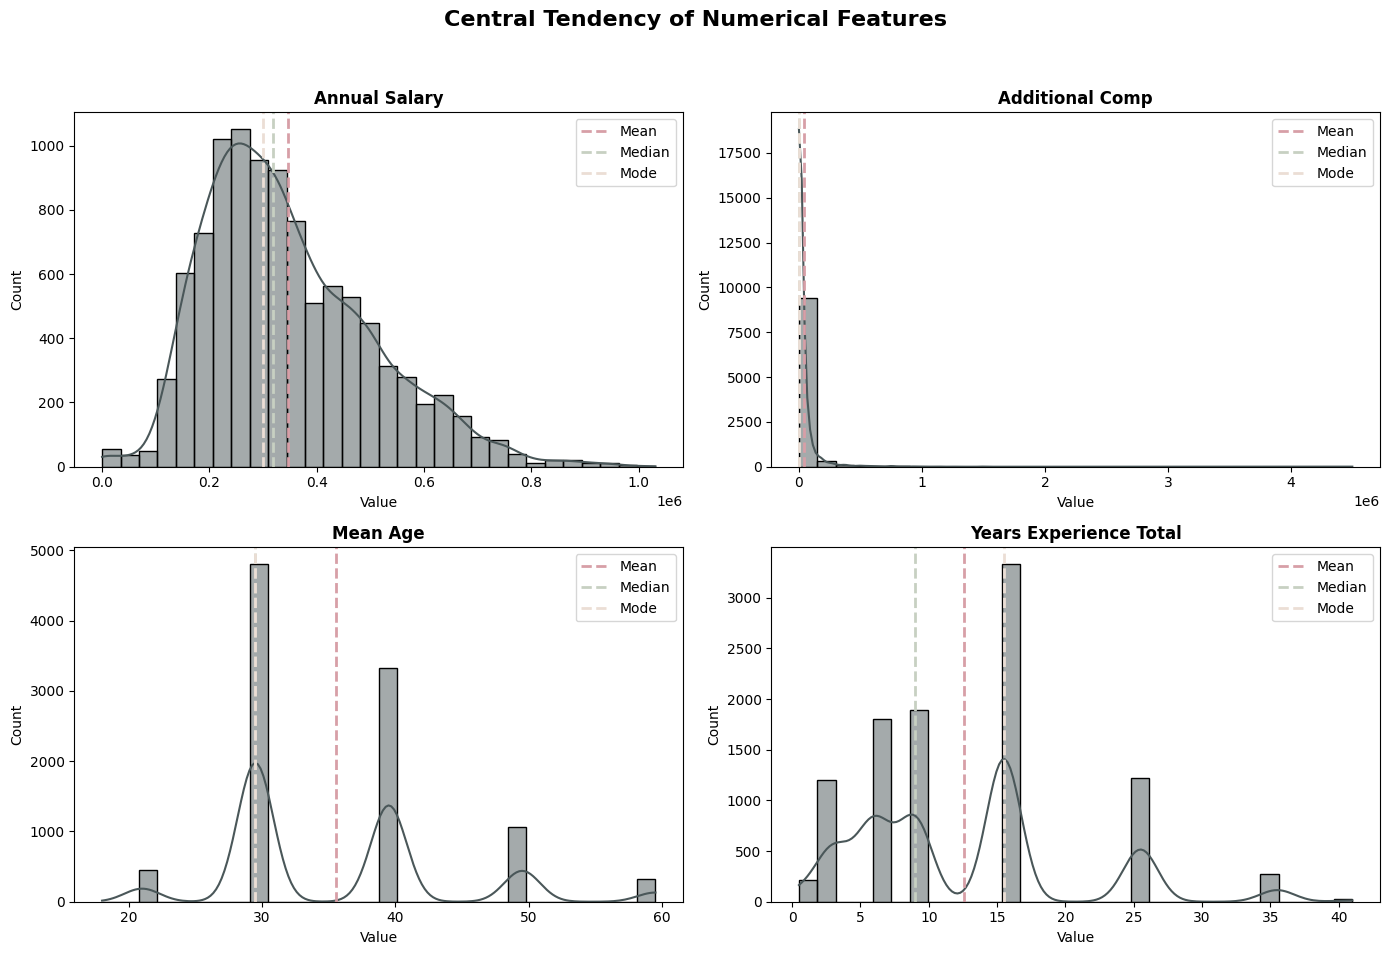

In [173]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Central Tendency of Numerical Features", fontsize=16, fontweight='bold')

for i, feature in enumerate(numerics):
    row, col = divmod(i, 2)  

    sns.histplot(df[feature], bins=30, kde=True, ax=axes[row, col], color="#4A5759")

    axes[row, col].axvline(df[feature].mean(), color='#D79FA7', linestyle='dashed', linewidth=2, label="Mean")
    axes[row, col].axvline(df[feature].median(), color='#C7D0C2', linestyle='dashed', linewidth=2, label="Median")
    axes[row, col].axvline(df[feature].mode().values[0], color='#EBDED5', linestyle='dashed', linewidth=2, label="Mode")

    
    axes[row, col].set_title(feature.replace("_", " ").title(), fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel("Value", fontsize=10)
    axes[row, col].legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Since skewness in the dataset is expected (additional compensation is usually zero for many, and annual salary outliers were removed within each job level). Overall, the median represents values better than the mean, capturing the central tendency of salaries, compensation, age, and experience without being affected by extremes.

### Measures of Association

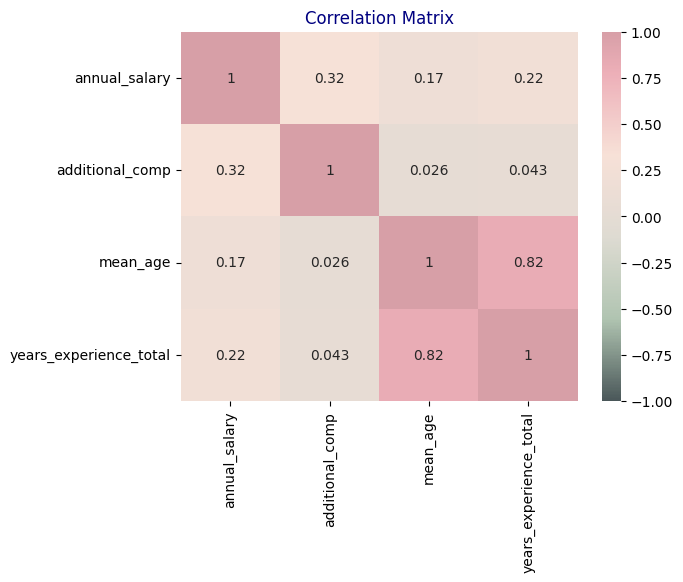

In [174]:
numerics = df[['annual_salary', 'additional_comp', 'mean_age','years_experience_total']]

corr_mat = numerics.corr()

# Create mask to hide duplicated info
corr_mask = np.triu(np.ones_like(corr_mat, dtype=bool), k =1)

# Set up figure
colors = [
    "#D79FA7",
    "#EDAFB8",
    "#F2C8C8",
    "#F7E1D7",
    "#EBDDD5",
    "#DEDBD2",
    "#C7D0C2",
    "#B0C4B1",
    "#7D8E85",
    "#4A5759"
]
colors_reversed = colors[::-1]
colours_cmap = LinearSegmentedColormap.from_list(
    "COLOURS",
    colors_reversed
)

corrmat = sns.heatmap(corr_mat,annot = True, cmap=colours_cmap, vmin=-1, vmax=1)
plt.title('Correlation Matrix', color='navy')

# Show heatmap
plt.show()

The correlation matrix is used to analyze the strength and direction of relationships.

**Correlation values range from -1 to +1:**

	•	+1 → Perfect positive correlation
	•	0 → No correlation
	•	-1 → Perfect negative correlation

**Key Observations:** 

Correlation = 0.82

There is strong positive correlation between Mean Age vs Years of Experience
	
Correlation = 0.32

There is moderate positive correlation between annual_salary vs additional comp

Employees with higher annual salaries tend to receive higher additional compensation.


Other correlations are weak positive correlations. 

Correlations = 0.026 and 0.043

These values indicate very weak or almost no correlation

**Conclusion:**

The strongest relationship exists between mean age and total years of experience, confirming consistency in the dataset

Salary and compensation are influenced by experience and age, but the relationships are relatively weak.

### Measures of Dispersion

Measures of Dispersion


,Standard Deviation,Range,IQR
annual_salary,155910.773602,1031250.0,209540.0
additional_comp,140560.365817,4500000.0,34875.0
mean_age,8.461655,41.5,10.0


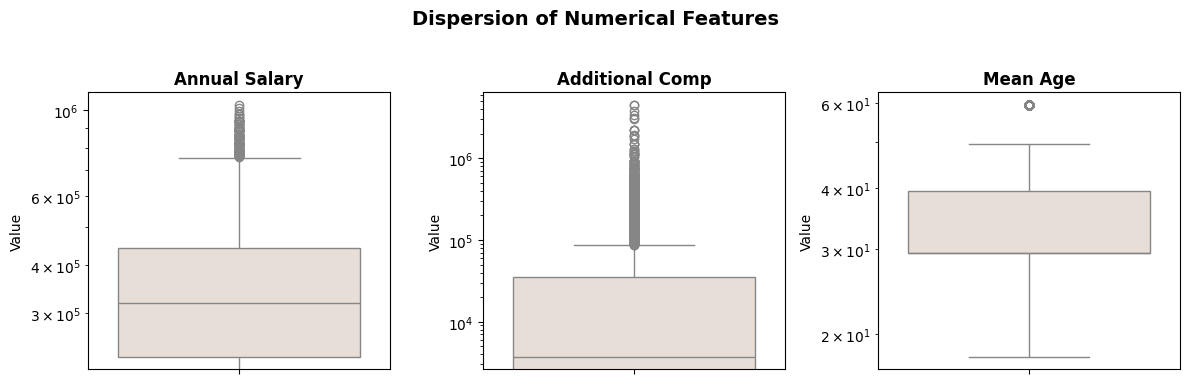

In [175]:
dispersion_features = ["annual_salary", "additional_comp", "mean_age"]

dispersion_stats = pd.DataFrame(index=dispersion_features)

dispersion_stats["Standard Deviation"] = df[dispersion_features].std()
dispersion_stats["Range"] = df[dispersion_features].max() - df[dispersion_features].min()
dispersion_stats["IQR"] = (df[dispersion_features].quantile(0.75)- df[dispersion_features].quantile(0.25))

print("Measures of Dispersion")
display(dispersion_stats)


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Dispersion of Numerical Features", fontsize=14, fontweight='bold')

for i, feature in enumerate(dispersion_features):
    sns.boxplot(y=df[feature], ax=axes[i], color="#EBDDD5")
    axes[i].set_yscale('log')
    axes[i].set_title(feature.replace("_", " ").title(), fontsize=12, fontweight='bold')
    axes[i].set_ylabel("Value", fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Annual salary is consistent within job levels because of outlier removal, additional compensation is highly spread because few individuals receive large amounts. Age shows little spread, with most individuals clustered around typical values.

In [176]:
# df.to_csv('cleaned_data.csv', index=False)

### Linear Regression Model

In [177]:
my_data = df
top_4 = my_data["annual_salary"].nlargest(4)
my_data = my_data[~my_data["annual_salary"].isin(top_4) & (my_data["annual_salary"] >= 1000)]

In [178]:
X = pd.get_dummies(my_data[["job_title", "work_country", "additional_comp", "years_experience_field", "education_level", "industry", "age", "job_level"]], drop_first=True)
y = np.log(my_data["annual_salary"])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=35
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("Train R²:", model.score(X_train, y_train))
print("Test  R²:", model.score(X_test, y_test))

Train R²: 0.5399346132780443
Test  R²: 0.4856756952418222


In [179]:
# R²
r2 = r2_score(y_test, y_pred)

# RMSE (log scale)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))

# MSE 
mse = mean_squared_error(y_test, y_pred)

# Convert back to salary scale
y_true = np.exp(y_test)
y_hat = np.exp(y_pred)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs(y_hat - y_true) / y_true) * 100


print(f"R² (test): {r2:.4f}")
print(f"MSE (log scale): {mse:.4f}")
print(f"RMSE (log scale): {rmse_log:.4f}")
print(f"MAPE (% error): {mape:.2f}%")

R² (test): 0.4857
MSE (log scale): 0.1153
RMSE (log scale): 0.3396
MAPE (% error): 27.87%


#### Result Explanation
1 - R² (test) = 0.4857 -->
The model explains almost 49% of the variance in salaries on unseen data.

2 - MSE = 0.1153 -->
The model's errors are very infrequent.

3 - RMSE = 0.3396 -->
e^0.3396 − 1 ≈ 40% -->
Typical predictions deviate by ~35–40%

4 - MAPE = 27.87% -->
Predictions are off by 27.87% on average

#### Overall performance summary

The linear regression model demonstrates moderate predictive performance, explaining almost half of the variance in salary outcomes. While the model captures extensive salary trends and effects such as geography and job role, prediction errors are still present at individual levels. This implies that the model is more suitable for analyzing and illustrating trends than precise salary predection.

In [180]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(
    model,
    X,
    y,
    scoring="r2",
    cv=8
)
print("Cross Validation Scores:")
print("Mean R²:", scores.mean())
print("Std R²:", scores.std())

Cross Validation Scores:
Mean R²: 0.4539557117811486
Std R²: 0.04826500123710619


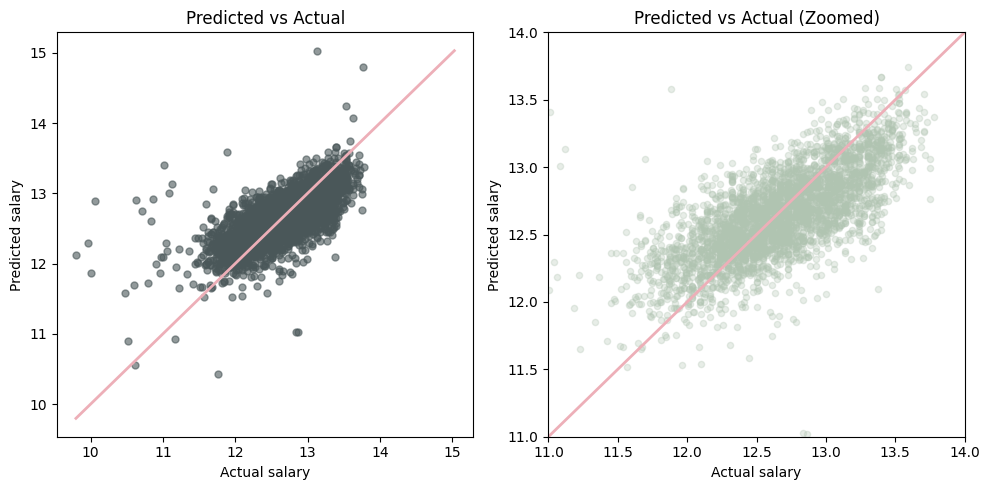

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].scatter(y_test, y_pred, alpha=0.6, s=25, color="#4A5759")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

axes[0].plot(
    [min_val, max_val],
    [min_val, max_val],
    color="#EDAFB8",
    linewidth=2
)

axes[0].set_xlabel("Actual salary")
axes[0].set_ylabel("Predicted salary")
axes[0].set_title("Predicted vs Actual")


# Zoomed scatter plot
axes[1].scatter(y_test, y_pred, alpha=0.3, s=20, color="#B0C4B1")

axes[1].plot(
    [11, 14],
    [11, 14],
    color="#EDAFB8",
    linewidth=2
)

axes[1].set_xlim(11, 14)
axes[1].set_ylim(11, 14)
axes[1].set_xlabel("Actual salary")
axes[1].set_ylabel("Predicted salary")
axes[1].set_title("Predicted vs Actual (Zoomed)")

plt.tight_layout()
plt.show()

#### Linear Regression Insights 

In [182]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lin_std = LinearRegression()
lin_std.fit(X_scaled, y)
std_coef = pd.Series(lin_std.coef_, index=X.columns).sort_values(key=abs, ascending=False)
print("Most Dominant Factors in Salary Prediction: \n")
display(std_coef)

#################

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)
print("\n \n Impact of Work Country on Salary: ")
display(coef_df)

Most Dominant Factors in Salary Prediction: 



work_country_USA          7.088386e-01
work_country_Canada       3.717217e-01
work_country_UK           3.432013e-01
work_country_Australia    1.999863e-01
job_title_Engineer        1.681194e-01
                              ...     
age_55-64                 8.025248e-04
job_title_Maintenance     4.948356e-04
job_title_Operations     -4.214906e-04
job_title_Quality        -3.189611e-04
age_65 or over           -3.903128e-18
Length: 157, dtype: float64


 
 Impact of Work Country on Salary: 


,Feature,Coefficient
121,work_country_Slovakia,1.444478
85,work_country_China,1.384301
81,work_country_Bangladesh,0.896565
116,work_country_Portugal,0.840489
106,work_country_Luxembourg,0.822627
...,...,...
86,work_country_Colombia,-1.522512
88,work_country_Cuba,-1.620057
95,work_country_Ghana,-1.637982
124,work_country_Sri Lanka,-1.943809


The linear regression results indicate that geographic location is the strongest determinant of salary. For example, working in Slovakia or China is associated with higher salaries. On the contrary, working in Turkey is associated with lower salaries. Job roles such as engineering are associated with moderately higher salaries, while age shows no meaningful effect. These insights imply that structural factors outweigh individual demographics.

### SVM Classifier

In [183]:
df["additional_comp"] = df["additional_comp"].fillna(0)
df["work_state"] = df["work_state"].fillna("unknown")
df = df.dropna(subset=["annual_salary"])

In [184]:
# Apply log transformation to reduce skewness in annual salary values
df["annual_salary"] = pd.to_numeric(df["annual_salary"], errors='coerce')

df = df.dropna(subset=["annual_salary"])

df["salary_log"] = np.log1p(df["annual_salary"])

low = df["salary_log"].quantile(0.01)
high = df["salary_log"].quantile(0.99)

df["salary_final"] = df["salary_log"].clip(low, high)

In [185]:
# Create equal-bridth bins
df["salary_cat"] = pd.qcut(df["annual_salary"], 3, labels=False,duplicates='drop')

# Map numeric bins to descriptive labels
labels = ["low", "medium", "high"]  # 3 labels to match 3 bins
df["salary_cat_label"] = df["salary_cat"].map(lambda x: labels[x])

In [186]:
# Education has a natural order, we use Ordinal Encoding
education_order = [
    "high school",
    "some college",
    "college degree",
    "master's degree",
    "phd",
    "professional degree (md, jd, etc.)"
]

edu_encoder = OrdinalEncoder(
    categories=[education_order],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

df["education_level_encoded"] = edu_encoder.fit_transform(
    df[["education_level"]]
)

#age has a natural order, we use Ordinal Encoding
age_order = [
    "under 18",
    "18-24",
    "25-34",
    "35-44",
    "45-54",
    "55-64",
    "65 or over"
]

age_encoder = OrdinalEncoder(
    categories=[age_order],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

df["age_encoded"] = age_encoder.fit_transform(
    df[["age"]]
)

job_level_order = [
    "Junior",
    "Mid",
    "Senior",
    "Lead",
    "Manager",
    "Director",
    "Executive"
]

job_encoder = OrdinalEncoder(
    categories=[job_level_order],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

df["job_level_encoded"] = job_encoder.fit_transform(
    df[["job_level"]]
)

# Gender One-HotEncoder
gender_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
gender_encoded = gender_encoder.fit_transform(df[["gender"]])

gender_df = pd.DataFrame(
    gender_encoded,
    columns=gender_encoder.get_feature_names_out(["gender"]),
    index=df.index
)
df = pd.concat([df, gender_df], axis=1)

race_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
race_encoded = race_encoder.fit_transform(df[["race"]])

race_df = pd.DataFrame(
    race_encoded,
    columns= race_encoder.get_feature_names_out(["race"]),
    index=df.index
)
df = pd.concat([df, race_df], axis=1)

# Country One-Hot Encoding
country_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
country_encoded = country_encoder.fit_transform(df[["work_country"]])

country_df = pd.DataFrame(
    country_encoded,
    columns=country_encoder.get_feature_names_out(["work_country"]),
    index=df.index 
)
df = pd.concat([df, country_df], axis=1)


# industry OneHot Encoding
industry_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)
industry_encoded = industry_encoder.fit_transform(df[["industry"]])

industry_df = pd.DataFrame(
    industry_encoded,
    columns=industry_encoder.get_feature_names_out(["industry"]),
    index=df.index
)
df = pd.concat([df, industry_df], axis=1)


# Job title One-Hot Encoding 
job_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
job_encoded = job_encoder.fit_transform(df[["job_title"]])

job_df = pd.DataFrame(
    job_encoded,
    columns=job_encoder.get_feature_names_out(["job_title"]),
    index=df.index
)

df = pd.concat([df, job_df], axis=1)

# Work_state One-Hot Encoding
state_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)

state_encoded = state_encoder.fit_transform(df[["work_state"]])

state_df = pd.DataFrame(
    state_encoded,
    columns=state_encoder.get_feature_names_out(["work_state"]),
    index=df.index
)

df = pd.concat([df, state_df], axis=1)

In [187]:
# Prepare X and y
numeric_cols = [
    "education_level_encoded",
    "age_encoded",
    "years_experience_total",
    "years_experience_field",
    "additional_comp",
    "job_level_encoded"
]

categorical_ohe_cols = (
    list(gender_df.columns)
    + list(race_df.columns)
    + list(country_df.columns)
    + list(industry_df.columns)
    + list(job_df.columns)
    +list(state_df.columns)
)

X = df[numeric_cols + categorical_ohe_cols]
y = df["salary_cat"]

In [188]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [189]:
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [190]:
# Train SVM classifier
svm_clf = SVC(kernel="rbf", C=1.0, gamma="scale")  # RBF kernel is common
svm_clf.fit(X_train, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

Accuracy: 0.6486215538847118

Confusion Matrix:
 [[489 148  29]
 [169 360 141]
 [ 38 176 445]]

Classification Report:
               precision    recall  f1-score   support

         low       0.70      0.73      0.72       666
      medium       0.53      0.54      0.53       670
        high       0.72      0.68      0.70       659

    accuracy                           0.65      1995
   macro avg       0.65      0.65      0.65      1995
weighted avg       0.65      0.65      0.65      1995



#### SVM Insights 

Precision: measures the proportion of correct positive predictions per class.

Recall: indicates how many true positives were correctly identified.

F1-score:  balances precision and recall.


Overall performance: 

The classification model shows moderate performance in predicting salary categories. It effectively identifies low and high salary classes but struggles with the medium category, likely due to overlap with the other two classes. This indicates the model is better suited for broad salary trend analysis rather than highly accurate predictions at the individual level.

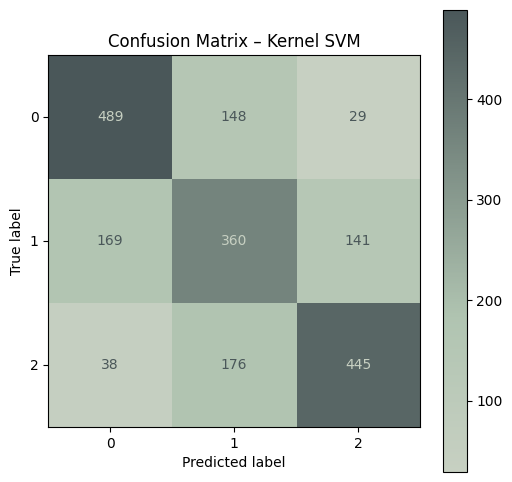

In [191]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=svm_clf.classes_
)

colors = [
    "#C7D0C2",
    "#B0C4B1",
    "#7D8E85",
    "#4A5759"
]

colors_reversed = colors[::-1]
colours_cmap = LinearSegmentedColormap.from_list(
    "COLOURS",
    colors
)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(
    cmap=colours_cmap,
    values_format="d",
    ax=ax
)

plt.title("Confusion Matrix – Kernel SVM")
plt.grid(False)
plt.show()

The diagonal values represent correctly classified samples for each class.
The model performs best for the low and high classes, with some confusion in the medium class.